# AGU Plots 

In [1]:
# load modules 

import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm
%matplotlib inline
import os 
from xgcm import Grid
from xarrayutils import aggregate
import copy
# Pseudo Inversion 
from scipy.linalg import pinv, eig

In [2]:
import matplotlib.colors as colors

In [5]:
Model_Tav = xr.open_dataset('Model_Tav_AGU.nc')

In [6]:
Trac_Tav = xr.open_dataset('Trac_Tav_AGU.nc')

In [12]:
ds_inst = xr.open_dataset('Inst_fields_AGU.nc')

In [70]:
UpCp = xr.open_dataarray('UpCp_AGU.nc')
VpCp = xr.open_dataarray('VpCp_AGU.nc')
WpCp = xr.open_dataarray('WpCp_AGU.nc')
dCdx = xr.open_dataarray('dCdx_AGU.nc')
dCdy = xr.open_dataarray('dCdy_AGU.nc')
dCdz = xr.open_dataarray('dCdz_AGU.nc')

In [71]:
Ktensor_corr = xr.open_dataarray('Ktensor_AGU.nc')

In [ ]:
T_coarse = xr.open_dataset('Tcoarse_AGU.nc')

In [83]:
Ktensor_corrT = Ktensor_corr.transpose('XCicoarse','YCicoarse','Z','j','i')

ST = 0.5*(Ktensor_corr.data + Ktensor_corrT.data)
AT = 0.5*(Ktensor_corr.data - Ktensor_corrT.data)

ST = xr.DataArray(ST, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)
AT = xr.DataArray(AT, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)

In [84]:
# calculate the eigenvalues and eigenvectors of symmetric part
eigvalsST, eigvecsST = xr.apply_ufunc(eig, ST, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

In [88]:
# Naive attempt to calculate Kgm 
KgmY =  AT.isel(i=2, j=1)/T_coarse['Siso_Y'].where(T_coarse.T_Z>2e-4)
KgmX = AT.isel(i=2, j=0)/T_coarse['Siso_X'].where(T_coarse.T_Z>2e-4)

In [73]:
recUflux_corr = -(Ktensor_corr.sel(i=0, j=0)*dCdx + Ktensor_corr.sel(i=0, j=1)*dCdy + \
                Ktensor_corr.sel(i=0, j=2)*dCdz)
recVflux_corr = -(Ktensor_corr.sel(i=1, j=0)*dCdx + Ktensor_corr.sel(i=1, j=1)*dCdy + \
                Ktensor_corr.sel(i=1, j=2)*dCdz)
recWflux_corr = -(Ktensor_corr.sel(i=2, j=0)*dCdx + Ktensor_corr.sel(i=2, j=1)*dCdy +  \
                Ktensor_corr.sel(i=2, j=2)*dCdz)
    
errU_corr = np.abs(UpCp - recUflux_corr)/np.abs(UpCp)
errV_corr = np.abs(VpCp - recVflux_corr)/np.abs(VpCp)
errW_corr = np.abs(WpCp - recWflux_corr)/np.abs(WpCp)   

In [78]:
recUB_corr = -(Ktensor_corr.sel(i=0, j=0)*T_coarse.T_X + \
             Ktensor_corr.sel(i=0, j=1)*T_coarse.T_Y + \
             Ktensor_corr.sel(i=0, j=2)*T_coarse.T_Z)
recVB_corr = -(Ktensor_corr.sel(i=1, j=0)*T_coarse.T_X + \
             Ktensor_corr.sel(i=1, j=1)*T_coarse.T_Y + \
             Ktensor_corr.sel(i=1, j=2)*T_coarse.T_Z)
recWB_corr = -(Ktensor_corr.sel(i=2, j=0)*T_coarse.T_X + \
             Ktensor_corr.sel(i=2, j=1)*T_coarse.T_Y + \
             Ktensor_corr.sel(i=2, j=2)*T_coarse.T_Z)

errUB_corr = np.abs(T_coarse.UpTp - recUB_corr)/np.abs(T_coarse.UpTp)
errVB_corr = np.abs(T_coarse.VpTp - recVB_corr)/np.abs(T_coarse.VpTp)
errWB_corr = np.abs(T_coarse.WpTp - recWB_corr)/np.abs(T_coarse.WpTp)

In [7]:
X = Trac_Tav.XC
Y = Trac_Tav.YC
Z = Trac_Tav.Z

In [10]:
font = {'family' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rc('text', usetex=True)

In [25]:
grid = Grid(Model_Tav, periodic='X')

# Experimental Setup

In [26]:
MKE = grid.interp(Model_Tav.uVeltave,'X')**2 + \
    grid.interp(Model_Tav.vVeltave, 'Y', boundary='extend')**2
    
KE = grid.interp(Model_Tav.UUtave,'X')**2 + \
    grid.interp(Model_Tav.VVtave, 'Y', boundary='extend')**2

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)


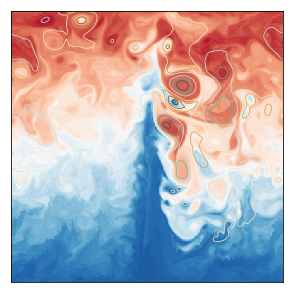

In [158]:
levs = [-0.7,-0.55,-0.35,-0.15,0.15, 0.35,0.55,0.7]
fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.pcolormesh(X/1e3, Y/1e3, ds_inst['T'].isel(Z=5,time=0), 
                      vmin=0, vmax=8, cmap='RdBu_r', rasterized=True)
#cbar = fig.colorbar(im, ax=ax)
#cbar.ax.set_ylabel('T ($^oC$)')
ax.contour(X/1e3, Y/1e3, (ds_inst.Eta.isel(time=0) - Model_Tav.ETAtave), 
              levels=levs, cmap='BrBG', linewidths=0.75, rasterized=True)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])


plt.savefig('T_var.pdf', dpi=400)
# use rasterized option, or else the file is much bigger in size. 

[]

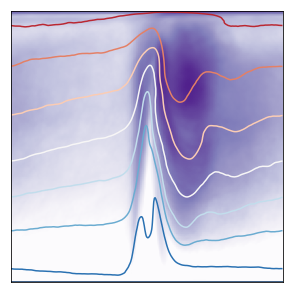

In [32]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.pcolormesh(X/1e3,Y/1e3, KE.isel(Z=0),  norm=colors.LogNorm(vmin=1e-4, vmax=1),
                   vmin=1e-4, vmax=1, cmap='Purples', rasterized=True)
#cbar = fig.colorbar(im, ax=ax)
#cbar.ax.set_ylabel('KE ($m^2/s^2$)')
ax.contour(X/1e3, Y/1e3, Model_Tav.Ttave.isel(Z=0), levels=np.linspace(0,8,9),
              cmap='RdBu_r', rasterized=True)
ax.set_aspect('equal')
#ax.set_xlabel('X (km)')
#ax.set_ylabel('Y (km)')
ax.set_xticks([])
ax.set_yticks([])

# alternatively
#ax.set_xticklabels([])
#ax.set_yticklabels([])



# Tracers 

Plots of C*, C_bar, C_grad, C_eddyflux, C_recreatedflux

In [34]:
Lx = 2000e3
C1 = Z/Z*Y/Lx*X/X
C3 =  Z/Z*Y/Y*np.cos(2 *np.pi *X/Lx)

[]

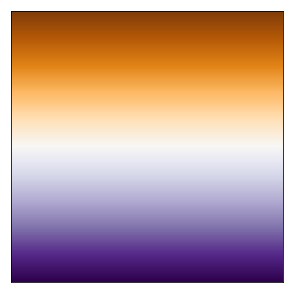

In [39]:
# Value restored to 

fig, ax = plt.subplots(1,1, figsize=(6,5))

ax.pcolormesh(X/1e3, Y/1e3, C1.sel(Z=-1500, method='nearest'), vmax=1, 
                      cmap='PuOr_r', rasterized=True)
#fig.colorbar(im, ax=ax[0])
#ax.contour(X/1e3, Y/1e3, Trac_Tav.TRAC01.sel(Z=-1500, method='nearest'), 
#              vmin=0, vmax=1,levels=np.linspace(0,1,10), cmap='Greys', rasterized=True)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)


[]

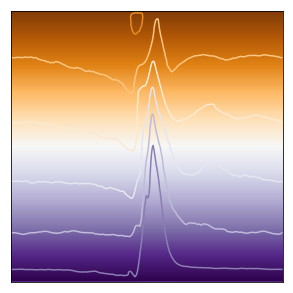

In [76]:
# Value restored to and equilibirum overlaid in same color (when they are similar the colors mix, and can't see contours)

fig, ax = plt.subplots(1,1, figsize=(6,5))

ax.pcolormesh(X/1e3, Y/1e3, C1.sel(Z=-1500, method='nearest'), vmax=1, 
                      cmap='PuOr_r', rasterized=True)
#fig.colorbar(im, ax=ax[0])
ax.contour(X/1e3, Y/1e3, Trac_Tav.TRAC01.sel(Z=-1500, method='nearest'), 
              vmin=0, vmax=1,levels=np.linspace(0,1,10), cmap='PuOr_r', rasterized=True)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

[]

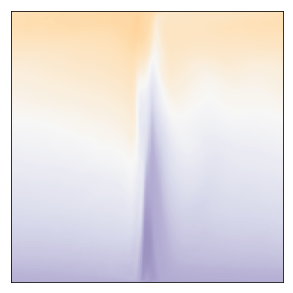

In [62]:
# Equlibrium structure ( contors overlaid on previous plot are better in my opinion)

fig, ax = plt.subplots(1,1, figsize=(6,5))

#ax.pcolormesh(X/1e3, Y/1e3, C1.sel(Z=-1500, method='nearest'), vmax=1, 
#                      cmap='Greys', rasterized=True)
ax.pcolormesh(X/1e3, Y/1e3, Trac_Tav.TRAC02.sel(Z=-1500, method='nearest'), 
              vmin=0, vmax=1, cmap='PuOr_r', rasterized=True)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

In [48]:
Xcoarse= UpCp.Xcoarse
Ycoarse= UpCp.Ycoarse

[]

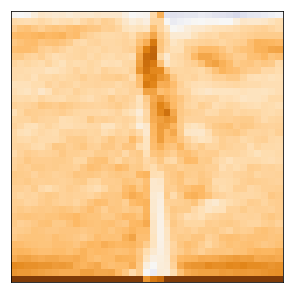

In [58]:
# gradients 

fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.pcolormesh(Xcoarse/1e3, Ycoarse/1e3, dCdy.isel(
    tracer_num=0).sel(Z=-1500, method='nearest').T , cmap='PuOr_r', 
               vmin=-1e-6, vmax=1e-6, rasterized=True)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

# incase colorbar is needed
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.81, 0.2, 0.01, 0.65])
#fig.colorbar(im, cax=cbar_ax, format='%.0e')

[]

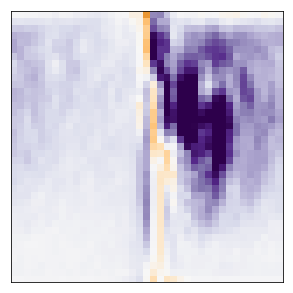

In [68]:
# fluxes

fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.pcolormesh(Xcoarse/1e3, Ycoarse/1e3, VpCp.isel(
    tracer_num=0).sel(Z=-1500, method='nearest').T , cmap='PuOr_r', 
               vmin=-2e-3, vmax=2e-3, rasterized=True)

ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

# incase colorbar is needed
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.81, 0.2, 0.01, 0.65])
#fig.colorbar(im, cax=cbar_ax, format='%.0e')

[]

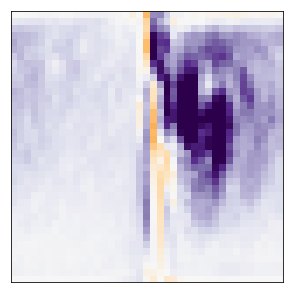

In [74]:
# Recreated fluxes

fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.pcolormesh(Xcoarse/1e3, Ycoarse/1e3, recVflux_corr.isel(
    tracer_num=0).sel(Z=-1500, method='nearest').T , cmap='PuOr_r', 
               vmin=-2e-3, vmax=2e-3, rasterized=True)

ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

[]

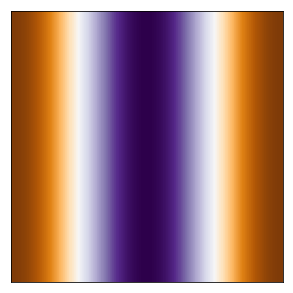

In [63]:
# Value restored to 

fig, ax = plt.subplots(1,1, figsize=(6,5))

ax.pcolormesh(X/1e3, Y/1e3, C3.sel(Z=-1500, method='nearest'), vmin=-1, vmax=1, 
                      cmap='PuOr_r', rasterized=True)
#fig.colorbar(im, ax=ax[0])
#ax.contour(X/1e3, Y/1e3, Trac_Tav.TRAC01.sel(Z=-1500, method='nearest'), 
#              vmin=0, vmax=1,levels=np.linspace(0,1,10), cmap='Greys', rasterized=True)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

[]

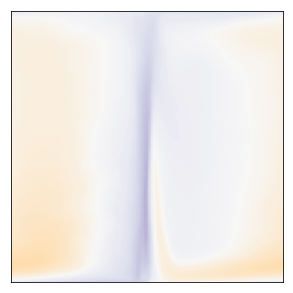

In [64]:
# Equlibrium structure ( contors overlaid on previous plot are better in my opinion)

fig, ax = plt.subplots(1,1, figsize=(6,5))

#ax.pcolormesh(X/1e3, Y/1e3, C1.sel(Z=-1500, method='nearest'), vmax=1, 
#                      cmap='Greys', rasterized=True)

ax.pcolormesh(X/1e3, Y/1e3, Trac_Tav.TRAC06.sel(Z=-1500, method='nearest'), 
              vmin=-1, vmax=1, cmap='PuOr_r', rasterized=True)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

[]

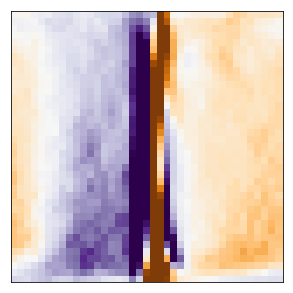

In [65]:
# gradients 

fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.pcolormesh(Xcoarse/1e3, Ycoarse/1e3, dCdx.isel(
    tracer_num=5).sel(Z=-1500, method='nearest').T , cmap='PuOr_r', 
               vmin=-1e-6, vmax=1e-6, rasterized=True)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

[]

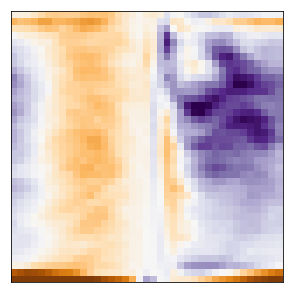

In [67]:
# fluxes

fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.pcolormesh(Xcoarse/1e3, Ycoarse/1e3, UpCp.isel(
    tracer_num=5).sel(Z=-1500, method='nearest').T , cmap='PuOr_r', 
               vmin=-2e-3, vmax=2e-3, rasterized=True)

ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

[]

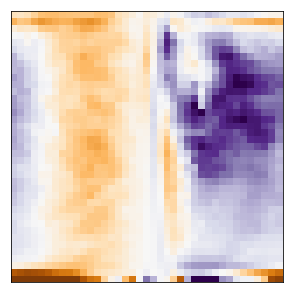

In [75]:
# Recreated fluxes

fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.pcolormesh(Xcoarse/1e3, Ycoarse/1e3, recUflux_corr.isel(
    tracer_num=5).sel(Z=-1500, method='nearest').T , cmap='PuOr_r', 
               vmin=-2e-3, vmax=2e-3, rasterized=True)

ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

# Errors 

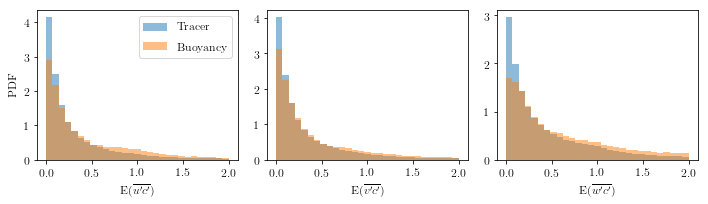

In [80]:
# Plot error histograms
bins = np.linspace(0,2,30)
weights = np.tile(bins[1], 30)

plt.figure(figsize=(10,3))

plt.subplot(131)
[_,_,_] = errU_corr.plot.hist(bins=bins, alpha=0.5,label='Tracer', density=True)
[_,_,_] = errUB_corr.plot.hist(bins=bins, alpha=0.5,label='Buoyancy', density=True)
plt.legend()
plt.xlabel('E($\overline{u\'c\'}$)')
plt.title('')
plt.ylabel('PDF')


plt.subplot(132)
[_,_,_] = errV_corr.plot.hist(bins=bins, alpha=0.5, density=True)
[_,_,_] = errVB_corr.plot.hist(bins=bins, alpha=0.5, density=True)
plt.xlabel('E($\overline{v\'c\'}$)')
plt.title('')

plt.subplot(133)
[_,_,_] = errW_corr.plot.hist(bins=bins, alpha=0.5,density=True)
[_,_,_] = errWB_corr.plot.hist(bins=bins, alpha=0.5,density=True)
plt.title('')
plt.xlabel('E($\overline{w\'c\'}$)')

plt.tight_layout()
#plt.savefig('error_pdf.pdf')

# Compare buoyancy to recreated

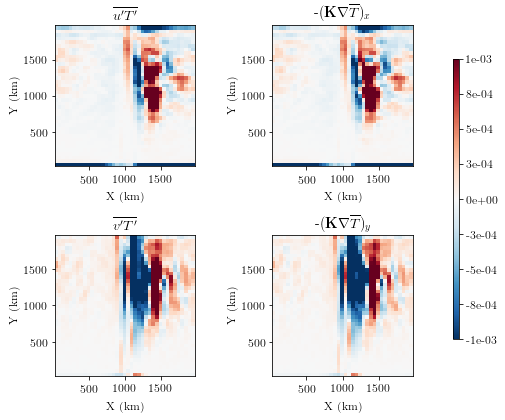

In [98]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.UpTp.sel(Z=-1500, method='nearest'),
                   vmin=-0.001, vmax=0.001, cmap='RdBu_r', rasterized=True)
ax[0,0].set_aspect('equal')
ax[0,0].set_title('$\overline{u\'T\'}$')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Y (km)')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, recUB_corr.sel(Z=-1500, method='nearest').T, 
                   vmin=-0.001, vmax=0.001, cmap='RdBu_r', rasterized=True)
ax[0,1].set_title(r'-$(\mathbf{K} \nabla \overline{T})_x$')
ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Y (km)')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-1500, method='nearest'),
                   vmin=-0.001, vmax=0.001, cmap='RdBu_r', rasterized=True)
ax[1,0].set_aspect('equal')
ax[1,0].set_title('$\overline{v\'T\'}$')
ax[1,0].set_xlabel('X (km)')
ax[1,0].set_ylabel('Y (km)')

im = ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, recVB_corr.sel(Z=-1500, method='nearest').T, 
                   vmin=-0.001, vmax=0.001, cmap='RdBu_r', rasterized=True)
ax[1,1].set_aspect('equal')
ax[1,1].set_title(r'-$(\mathbf{K} \nabla \overline{T})_y$')
ax[1,1].set_xlabel('X (km)')
ax[1,1].set_ylabel('Y (km)')


plt.tight_layout()


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax, format='%.0e')
#fig.colorbar(im, ax=ax.ravel().tolist())

#plt.savefig('reconstructed_temp_eddy_flux_1500m.pdf', dpi=400)

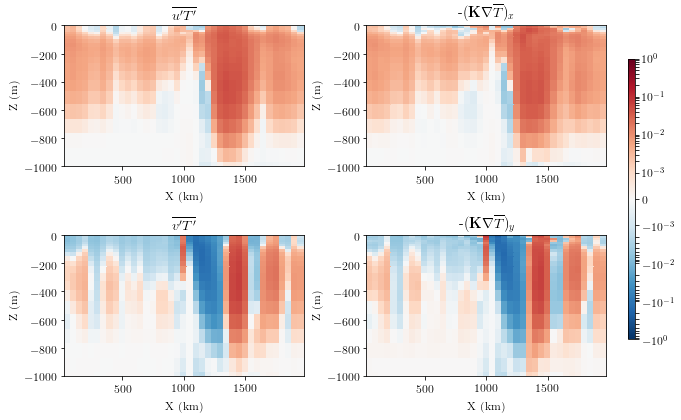

In [99]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

ax[0,0].pcolormesh(Xcoarse/1e3, Z, T_coarse.UpTp.sel(YCicoarse=20, method='nearest'),
                   vmin=-1, vmax=1, cmap='RdBu_r', norm = colors.SymLogNorm(linthresh=1e-3), 
                 rasterized=True)
#ax[0,0].set_aspect('equal')
ax[0,0].set_ylim([-1000,0])
ax[0,0].set_title('$\overline{u\'T\'}$')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Z (m)')

im = ax[0,1].pcolormesh(Xcoarse/1e3, Z, recUB_corr.sel(YCicoarse=20, method='nearest').T, 
                    cmap='RdBu_r', norm = colors.SymLogNorm(linthresh=1e-3, vmin=-1, vmax=1),  
                      rasterized=True)
#fig.colorbar(im, ax =ax[1])
ax[0,1].set_title(r'-$(\mathbf{K} \nabla \overline{T})_x$')
#ax[0,1].set_aspect('equal')
ax[0,1].set_ylim([-1000, 0])
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Z (m)')

ax[1,0].pcolormesh(Xcoarse/1e3, Z, T_coarse.VpTp.sel(YCicoarse=20, method='nearest'),
                   vmin=-1, vmax=1, cmap='RdBu_r', norm = colors.SymLogNorm(linthresh=1e-3), 
                 rasterized=True)
#ax[1,0].set_aspect('equal')
ax[1,0].set_ylim([-1000,0])
ax[1,0].set_title('$\overline{v\'T\'}$')
ax[1,0].set_xlabel('X (km)')
ax[1,0].set_ylabel('Z (m)')

im = ax[1,1].pcolormesh(Xcoarse/1e3, Z, recVB_corr.sel(YCicoarse=20, method='nearest').T, 
                    cmap='RdBu_r', norm = colors.SymLogNorm(linthresh=1e-3, vmin=-1, vmax=1),  
                      rasterized=True)
#fig.colorbar(im, ax =ax[1])
ax[1,1].set_title(r'-$(\mathbf{K} \nabla \overline{T})_y$')
#ax[1,1].set_aspect('equal')
ax[1,1].set_ylim([-1000, 0])
ax[1,1].set_xlabel('X (km)')
ax[1,1].set_ylabel('Z (m)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)


#plt.savefig('reconstructed_temp_eddy_flux_Y_1000km.pdf', dpi=400)

# plots of diff tensor

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)


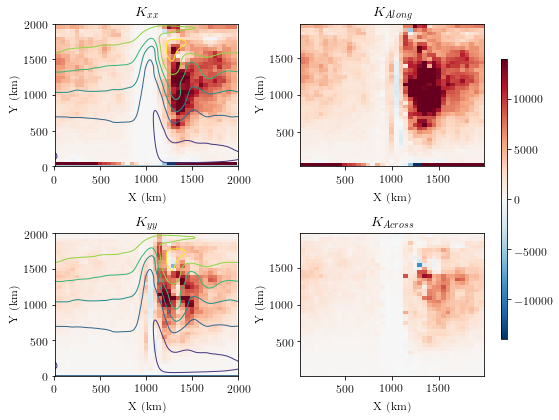

In [85]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, ST.isel(i=0,j=0).sel(Z=-1500, method='nearest').T,
                  vmin=-14000, vmax=14000, cmap='RdBu_r', rasterized=True)
ax[0,0].contour(X/1e3, Y/1e3, Model_Tav.ETAtave, levels=np.linspace(-0.5,0.5, 7)
               , rasterized=True, linewidths=1.)
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Y (km)')
ax[0,0].set_title('$K_{xx}$')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, np.real(eigvalsST).isel(ii=0).sel(Z=-1500, method='nearest').T,
                  vmin=-14000, vmax=14000, cmap='RdBu_r', rasterized=True)
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Y (km)')
ax[0,1].set_title('$K_{Along}$')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, ST.isel(i=1,j=1).sel(Z=-1500, method='nearest').T,
                  vmin=-14000, vmax=14000, cmap='RdBu_r', rasterized=True)
ax[1,0].contour(X/1e3, Y/1e3, Model_Tav.ETAtave, levels=np.linspace(-0.5,0.5, 7)
               , rasterized=True, linewidths=1.)
ax[1,0].set_xlabel('X (km)')
ax[1,0].set_ylabel('Y (km)')
ax[1,0].set_title('$K_{yy}$')

im =ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, np.real(eigvalsST).isel(ii=1).sel(Z=-1500, method='nearest').T,
                  vmin=-14000, vmax=14000, cmap='RdBu_r', rasterized=True)
ax[1,1].set_xlabel('X (km)')
ax[1,1].set_ylabel('Y (km)')
ax[1,1].set_title('$K_{Across}$')

plt.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

#plt.savefig('Khor_1500m.pdf', dpi=400)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)


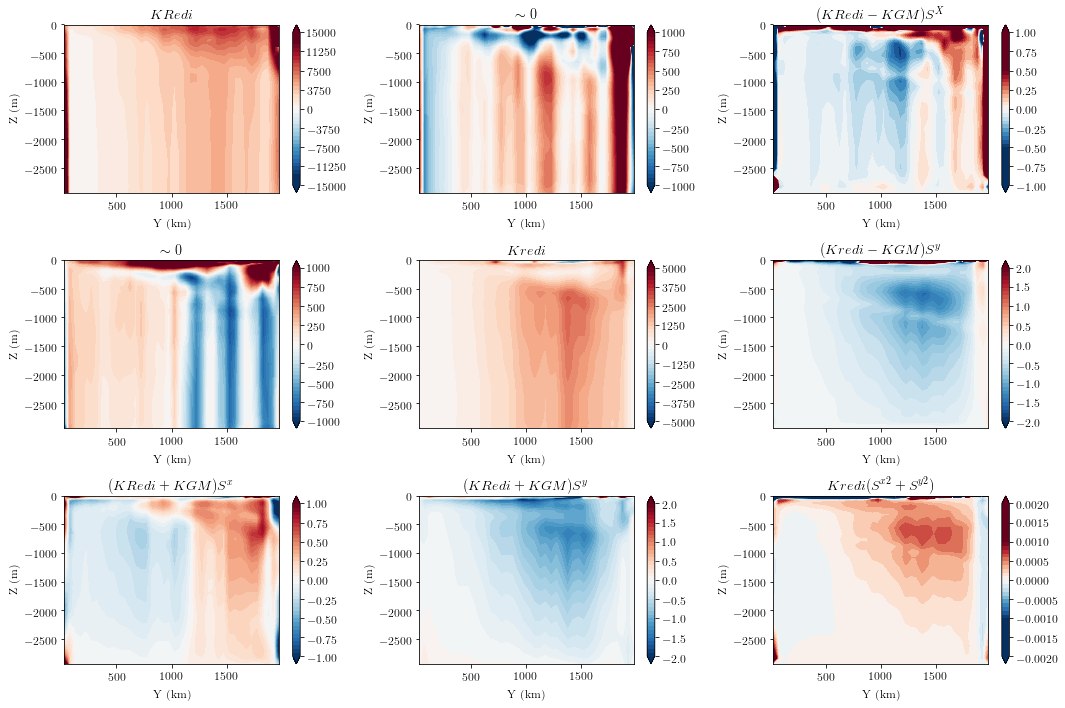

In [86]:
#  Full tensor 
# Can be used to show what the method recovers 

fig , ax = plt.subplots(3,3,figsize=(15,10))

im = ax[0,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-13000, vmax=13000, levels=np.linspace(-15e3, 15e3, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[0,0])
ax[0,0].set_title('$KRedi$')
ax[0,0].set_xlabel('Y (km)')
ax[0,0].set_ylabel('Z (m)')

im = ax[0,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), extend='both', cmap='RdBu_r', rasterized=True)
#ax[0,1].contour(Y/1e3, Z, np.abs(Model_Tav.uVeltave.sel(XG=slice(0,400e3)).mean('XG')), 
#                vmin=0, vmax=0.12, levels=np.linspace(0,0.12,11))
fig.colorbar(im , ax = ax[0,1])
ax[0,1].set_title('$\sim 0$')
ax[0,1].set_xlabel('Y (km)')
ax[0,1].set_ylabel('Z (m)')

im = ax[0,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[0,2])
ax[0,2].set_title('$(KRedi -KGM)S^X$')
ax[0,2].set_xlabel('Y (km)')
ax[0,2].set_ylabel('Z (m)')
##
im = ax[1,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), extend='both', cmap='RdBu_r', rasterized=True)
#ax[1,0].contour(Y/1e3, Z, np.abs(Model_Tav.uVeltave.sel(XG=slice(0,400e3)).mean('XG')), 
#                vmin=0, vmax=0.12, levels=np.linspace(0,0.12,11))
fig.colorbar(im , ax = ax[1,0])
ax[1,0].set_title('$\sim 0$')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

im = ax[1,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-5000, vmax=5000, levels=np.linspace(-5e3, 5e3, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[1,1])
ax[1,1].set_title('$Kredi$')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

im = ax[1,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[1,2])
ax[1,2].set_title('$(Kredi -KGM) S^y$')
ax[1,2].set_xlabel('Y (km)')
ax[1,2].set_ylabel('Z (m)')

##
im = ax[2,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1, vmax=1, levels=np.linspace(-1, 1, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[2,0])
ax[2,0].set_title('$(KRedi +KGM) S^x$')
ax[2,0].set_xlabel('Y (km)')
ax[2,0].set_ylabel('Z (m)')

im = ax[2,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[2,1])
ax[2,1].set_title('$(KRedi +KGM) S^y$')
ax[2,1].set_xlabel('Y (km)')
ax[2,1].set_ylabel('Z (m)')

im = ax[2,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1e-3, vmax=1e-3, levels=np.linspace(-2e-3, 2e-3, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[2,2])
ax[2,2].set_title('$Kredi ( S^{x2}+ S^{y2})$')
ax[2,2].set_xlabel('Y (km)')
ax[2,2].set_ylabel('Z (m)')

plt.tight_layout()

#plt.savefig('Ktensor_0_400km.pdf', dpi=400)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)


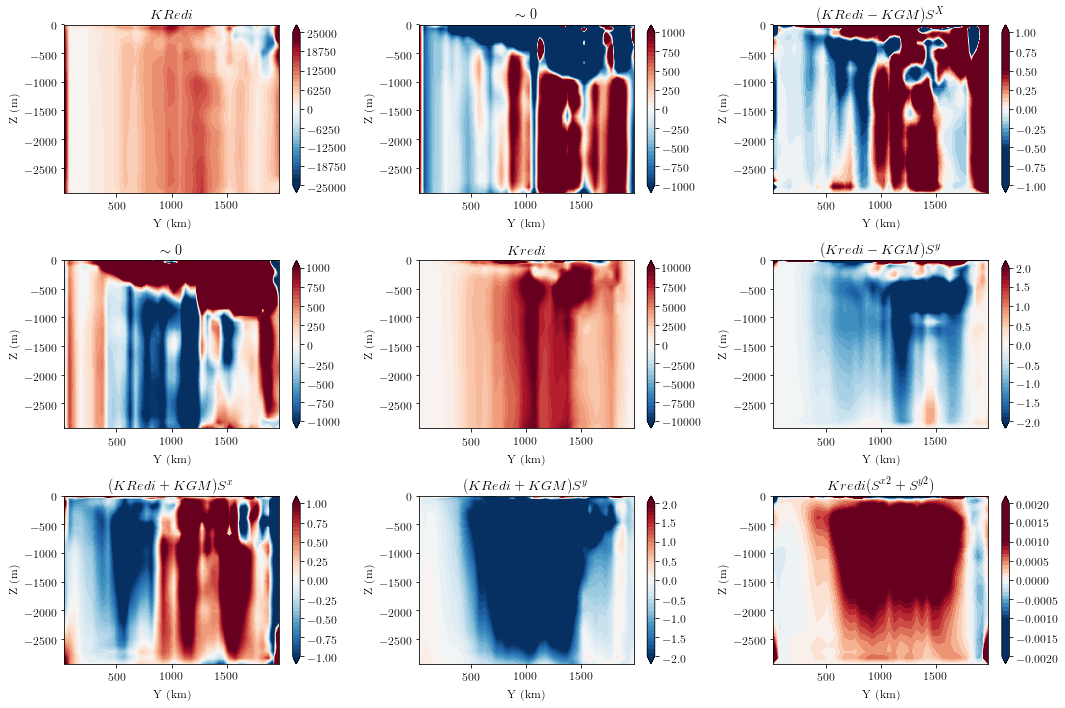

In [87]:
#  Full tensor (downstream region, but after the large meanders. So, in quasi-zonal part with large energy)
fig , ax = plt.subplots(3,3,figsize=(15,10))

im = ax[0,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=0).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-23000, vmax=23000, levels=np.linspace(-25e3, 25e3, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[0,0])
ax[0,0].set_title('$KRedi$')
ax[0,0].set_xlabel('Y (km)')
ax[0,0].set_ylabel('Z (m)')

im = ax[0,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=1).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), extend='both', cmap='RdBu_r', rasterized=True)
#ax[0,1].contour(Y/1e3, Z, np.abs(Model_Tav.uVeltave.sel(XG=slice(0,400e3)).mean('XG')), 
#                vmin=0, vmax=0.12, levels=np.linspace(0,0.12,11))
fig.colorbar(im , ax = ax[0,1])
ax[0,1].set_title('$\sim 0$')
ax[0,1].set_xlabel('Y (km)')
ax[0,1].set_ylabel('Z (m)')

im = ax[0,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=2).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[0,2])
ax[0,2].set_title('$(KRedi -KGM)S^X$')
ax[0,2].set_xlabel('Y (km)')
ax[0,2].set_ylabel('Z (m)')
##
im = ax[1,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=0).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), extend='both', cmap='RdBu_r', rasterized=True)
#ax[1,0].contour(Y/1e3, Z, np.abs(Model_Tav.uVeltave.sel(XG=slice(0,400e3)).mean('XG')), 
#                vmin=0, vmax=0.12, levels=np.linspace(0,0.12,11))
fig.colorbar(im , ax = ax[1,0])
ax[1,0].set_title('$\sim 0$')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

im = ax[1,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-10000, vmax=10000, levels=np.linspace(-10e3, 10e3, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[1,1])
ax[1,1].set_title('$Kredi$')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

im = ax[1,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=2).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[1,2])
ax[1,2].set_title('$(Kredi -KGM) S^y$')
ax[1,2].set_xlabel('Y (km)')
ax[1,2].set_ylabel('Z (m)')

##
im = ax[2,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=0).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-1, vmax=1, levels=np.linspace(-1, 1, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[2,0])
ax[2,0].set_title('$(KRedi +KGM) S^x$')
ax[2,0].set_xlabel('Y (km)')
ax[2,0].set_ylabel('Z (m)')

im = ax[2,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=1).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[2,1])
ax[2,1].set_title('$(KRedi +KGM) S^y$')
ax[2,1].set_xlabel('Y (km)')
ax[2,1].set_ylabel('Z (m)')

im = ax[2,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=2).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-1e-3, vmax=1e-3, levels=np.linspace(-2e-3, 2e-3, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[2,2])
ax[2,2].set_title('$Kredi ( S^{x2}+ S^{y2})$')
ax[2,2].set_xlabel('Y (km)')
ax[2,2].set_ylabel('Z (m)')

plt.tight_layout()

#plt.savefig('Ktensor_0_400km.pdf', dpi=400)

In [90]:
# Vertically average
KgmY_vermean = (KgmY * KgmY.drF).sum('Z') / KgmY.drF.sum('Z')
KgmX_vermean = (KgmX * KgmX.drF).sum('Z') / KgmX.drF.sum('Z')
KYY_vermean = (ST.isel(i=1,j=1)*ST.drF).sum('Z') / ST.drF.sum('Z')

# in next few figures refer to K_YY as K_redi (this is probably ok in regions where flow is almost zonal)

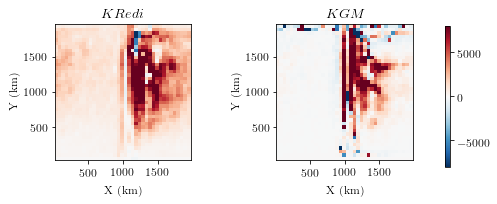

In [91]:
fig, ax = plt.subplots(1,2,figsize=(7.5,3))


im =ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, KYY_vermean.T,
            vmin=-8000, vmax=8000, cmap='RdBu_r'
            ,  rasterized=True)
#fig.colorbar(im, ax=ax[0])
ax[0].set_aspect('equal')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')
ax[0].set_title('$KRedi$')


im = ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, KgmY_vermean.T,
            vmin=-8000, vmax=8000, cmap='RdBu_r'
            ,  rasterized=True)
#fig.colorbar(im, ax=ax[1])
ax[1].set_aspect('equal')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')
ax[1].set_title('$KGM$')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)
#plt.savefig('K_ver_avg.pdf', dpi=400)


/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


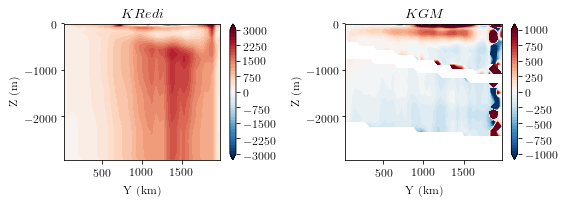

In [93]:
fig, ax = plt.subplots(1,2,figsize=(8,3))


im =ax[0].contourf(Ycoarse/1e3, Z, ST.isel(i=1,j=1).sel(XCicoarse=slice(0,16)).mean('XCicoarse').T,
            vmin=-3000, vmax=3000, cmap='RdBu_r', levels=np.linspace(-3000,3000,41)
            , extend='both', rasterized=True)
fig.colorbar(im, ax=ax[0])
ax[0].set_xlabel('Y (km)')
ax[0].set_ylabel('Z (m)')
ax[0].set_title('$KRedi$')


im = ax[1].contourf(Ycoarse/1e3, Z, KgmY.sel(XCicoarse=slice(0,16)).mean('XCicoarse').T,
            vmin=-1000, vmax=1000, cmap='RdBu_r', levels=np.linspace(-1000,1000,41)
            , extend='both', rasterized=True)
fig.colorbar(im, ax=ax[1])
ax[1].set_xlabel('Y (km)')
ax[1].set_ylabel('Z (m)')
ax[1].set_title('$KGM$')

plt.tight_layout()

#plt.savefig('K_0_800km.pdf', dpi=400)

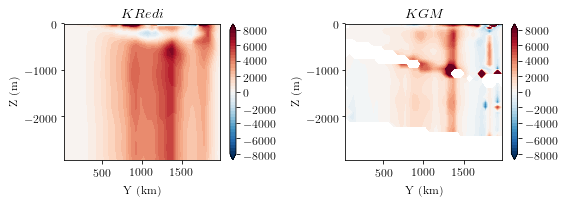

In [94]:
fig, ax = plt.subplots(1,2,figsize=(8,3))


im =ax[0].contourf(Ycoarse/1e3, Z, ST.isel(i=1,j=1).sel(XCicoarse=slice(30,40)).mean('XCicoarse').T,
            vmin=-8000, vmax=8000, cmap='RdBu_r', levels=np.linspace(-8000,8000,41)
            , extend='both', rasterized=True)
fig.colorbar(im, ax=ax[0])
ax[0].set_xlabel('Y (km)')
ax[0].set_ylabel('Z (m)')
ax[0].set_title('$KRedi$')


im = ax[1].contourf(Ycoarse/1e3, Z, KgmY.sel(XCicoarse=slice(30,40)).mean('XCicoarse').T,
            vmin=-8000, vmax=8000, cmap='RdBu_r', levels=np.linspace(-8000,8000,41)
            , extend='both', rasterized=True)
fig.colorbar(im, ax=ax[1])
ax[1].set_xlabel('Y (km)')
ax[1].set_ylabel('Z (m)')
ax[1].set_title('$KGM$')

plt.tight_layout()

#plt.savefig('K_1500_2000km.pdf', dpi=400)

# How well does the Antisymmetrix part of tensor recreate v'b'?

Don't compare well to full reconstruction as can be seen below. There was qualitative similarity in the zonally symmetric simulation. I suspect this has something to do with the off diagonal elements :$\psi3$ and likes of $S_{xy},S_{xz}$. However, this remains to be checked. 

In [111]:
recUB_AT = -(AT.sel(i=0, j=0)*T_coarse.T_X + \
           AT.sel(i=0, j=1)*T_coarse.T_Y + \
           AT.sel(i=0, j=2)*T_coarse.T_Z)

recVB_AT = -(AT.sel(i=1, j=0)*T_coarse.T_X + \
           AT.sel(i=1, j=1)*T_coarse.T_Y + \
           AT.sel(i=1, j=2)*T_coarse.T_Z)

Text(0.5, 0, 'X')

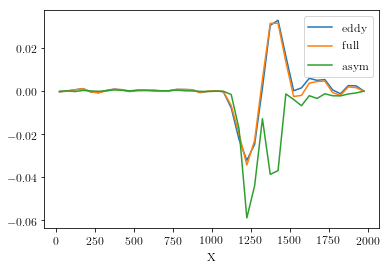

In [97]:
#plt.subplot(121)
plt.plot(Xcoarse/1e3, T_coarse.VpTp.sel(Z=-600, method='nearest').sel(YCicoarse=20), label='eddy')
plt.plot(Xcoarse/1e3, recVB_corr.sel(Z=-600, method='nearest').sel(YCicoarse=20),label='full')
plt.plot(Xcoarse/1e3, recVB_AT.sel(Z=-600, method='nearest').sel(YCicoarse=20), label='asym')
plt.legend()
plt.xlabel('X')

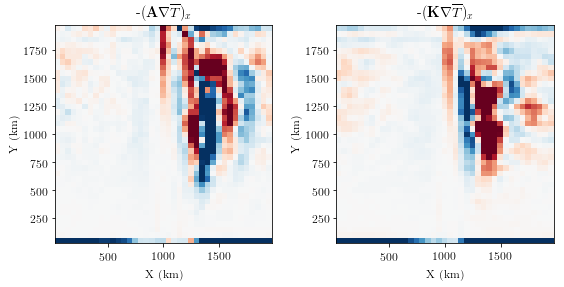

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6))

ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, recUB_AT.sel(Z=-1500, method='nearest').T,
                   vmin=-0.001, vmax=0.001, cmap='RdBu_r', rasterized=True)
ax[0].set_aspect('equal')
ax[0].set_title(r'-$(\mathbf{A} \nabla \overline{T})_x$')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')

ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, recUB_corr.sel(Z=-1500, method='nearest').T, 
                   vmin=-0.001, vmax=0.001, cmap='RdBu_r', rasterized=True)
ax[1].set_title(r'-$(\mathbf{K} \nabla \overline{T})_x$')
ax[1].set_aspect('equal')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')

plt.tight_layout()

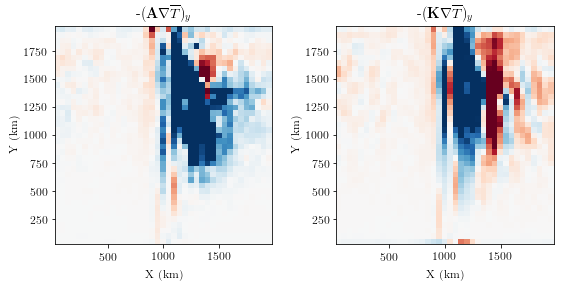

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6))

ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, recVB_AT.sel(Z=-1500, method='nearest').T,
                   vmin=-0.001, vmax=0.001, cmap='RdBu_r', rasterized=True)
ax[0].set_aspect('equal')
ax[0].set_title(r'-$(\mathbf{A} \nabla \overline{T})_y$')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')

ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, recVB_corr.sel(Z=-1500, method='nearest').T, 
                   vmin=-0.001, vmax=0.001, cmap='RdBu_r', rasterized=True)
ax[1].set_title(r'-$(\mathbf{K} \nabla \overline{T})_y$')
ax[1].set_aspect('equal')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')

plt.tight_layout()

# PV fluxes

Writing the PV fluxes in the EP flux form: 

$$ u'q' = (u'v')_x + (\frac{v'^2 - u'^2}{2})_y + \frac{(b'^2)_y}{2N^2} + (f_o \frac{u'b'}{N^2})_z$$

$$ v'q' = (\frac{v'^2 - u'^2}{2})_x - \frac{(b'^2)_x}{2N^2} +  -(u'v')_y +(f_o \frac{v'b'}{N^2})_z$$

In [114]:
# no spatial averaging
upvp = grid.interp(grid.interp(Model_Tav.UVtave , 'X'), 'Y', boundary='extend') \
                   - Model_Tav.UmeanC*Model_Tav.VmeanC
vpvp = grid.interp(Model_Tav.VVtave, 'Y', boundary='extend')  - Model_Tav.VmeanC**2
upup = grid.interp(Model_Tav.UUtave, 'X') - Model_Tav.UmeanC**2

uptp = Model_Tav.UTtave - Model_Tav.UmeanC*Model_Tav.Ttave
vptp = Model_Tav.VTtave - Model_Tav.VmeanC*Model_Tav.Ttave

tptp = Model_Tav.TTtave - Model_Tav.Ttave**2

N2 = -grid.interp(grid.diff(Model_Tav.Ttave, 'Z', boundary='extend'), 
                 'Z', boundary='extend')/Model_Tav.drF

In [115]:
dx = 5e3
dy = 5e3

g=9.81
alpha=2e-4
f0= -1.1e-4 
beta = 1.4e-11

In [116]:
# upqp
upqp1 =  grid.interp(grid.diff(upvp, 'X')/dx ,'X')
upqp2 = 0.5*grid.interp( grid.diff(vpvp -upup, 'Y', boundary='extend')/dy, 
                    'Y', boundary='extend')
upqp3 = 0.5*g*alpha/N2*grid.interp(grid.diff(tptp, 'Y', boundary='extend')/dy,
                          'Y', boundary='extend')
upqp4 = -f0*grid.interp( grid.diff(uptp/N2 ,'Z', boundary='extend'),
                      'Z', boundary='extend')/Model_Tav.drF
upqp = upqp1 + upqp2 + upqp3 + upqp4

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:997: RuntimeWarning: invalid value encountered in add
  return 0.5*(data_left + data_right)


In [117]:
# vpqp
vpqp1 = 0.5*grid.interp( grid.diff(vpvp -upup, 'X')/dx,'X')
vpqp2 = -0.5*g*alpha/N2*grid.interp(grid.diff(tptp, 'X')/dx,'X')
vpqp3 = -grid.interp(grid.diff(upvp, 'Y', boundary='extend')/dy ,
                      'Y', boundary='extend')
vpqp4 = -f0*grid.interp( grid.diff(vptp/N2 ,'Z', boundary='extend'),
                      'Z', boundary='extend')/Model_Tav.drF
vpqp = vpqp1 + vpqp2 + vpqp3 + vpqp4

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:997: RuntimeWarning: invalid value encountered in add
  return 0.5*(data_left + data_right)


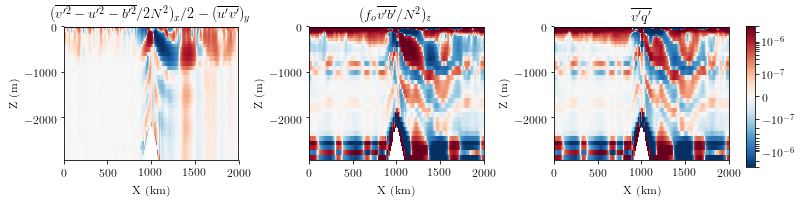

In [118]:
fig, ax = plt.subplots(1,3, figsize=(12,3))

im = ax[0].pcolormesh(X/1e3, Z, (vpqp1+vpqp2+vpqp3).sel(YC=1000e3, method='nearest') ,
                        vmin=-3e-6, vmax=3e-6, cmap='RdBu_r', norm=colors.SymLogNorm(linthresh=1e-7), rasterized=True)
ax[0].set_title('$(\overline{v\'^2 - u\'^2 -b\'^2}/2N^2)_x/2-(\overline{u\'v\'})_y$')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Z (m)')

im = ax[1].pcolormesh(X/1e3, Z, vpqp4.sel(YC=1000e3, method='nearest') ,
                        vmin=-3e-6, vmax=3e-6, cmap='RdBu_r', norm=colors.SymLogNorm(linthresh=1e-7), rasterized=True)
ax[1].set_title('$(f_o \overline{v\'b\'}/N^2)_z$')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Z (m)')

im = ax[2].pcolormesh(X/1e3, Z, (vpqp1+vpqp2+vpqp3+vpqp4).sel(YC=1000e3, method='nearest') ,
                        vmin=-3e-6, vmax=3e-6, cmap='RdBu_r', norm=colors.SymLogNorm(linthresh=1e-7), rasterized=True)
ax[2].set_title('$\overline{v\'q\'}$')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Z (m)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

#plt.savefig('PV_flux_components_XZ_1000km.pdf', dpi=400)

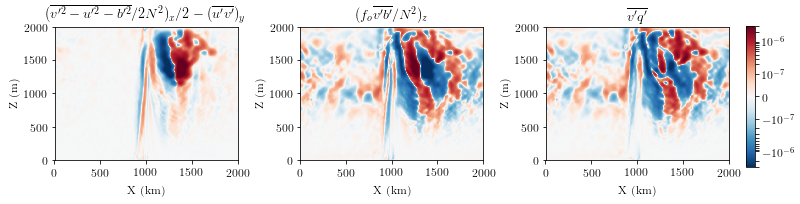

In [119]:
fig, ax = plt.subplots(1,3, figsize=(12,3))

im = ax[0].pcolormesh(X/1e3, Y/1e3, (vpqp1+vpqp2+vpqp3).sel(Z=-1000, method='nearest') ,
                        vmin=-3e-6, vmax=3e-6, cmap='RdBu_r', norm=colors.SymLogNorm(linthresh=1e-7), rasterized=True)
ax[0].set_title('$(\overline{v\'^2 - u\'^2 -b\'^2}/2N^2)_x/2-(\overline{u\'v\'})_y$')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Z (m)')

im = ax[1].pcolormesh(X/1e3, Y/1e3, vpqp4.sel(Z=-1000, method='nearest') ,
                        vmin=-3e-6, vmax=3e-6, cmap='RdBu_r', norm=colors.SymLogNorm(linthresh=1e-7), rasterized=True)
ax[1].set_title('$(f_o \overline{v\'b\'}/N^2)_z$')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Z (m)')

im = ax[2].pcolormesh(X/1e3, Y/1e3, vpqp.sel(Z=-1000, method='nearest') ,
                        vmin=-3e-6, vmax=3e-6, cmap='RdBu_r', norm=colors.SymLogNorm(linthresh=1e-7), rasterized=True)
ax[2].set_title('$\overline{v\'q\'}$')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Z (m)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

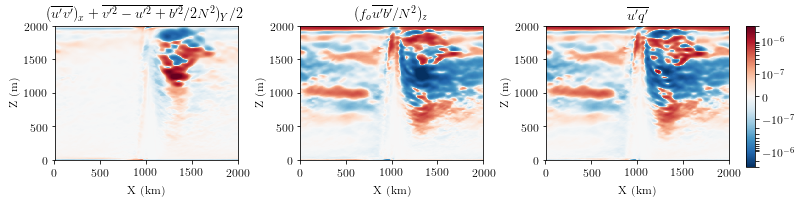

In [121]:
fig, ax = plt.subplots(1,3, figsize=(12,3))

im = ax[0].pcolormesh(X/1e3, Y/1e3, (upqp1+upqp2+upqp3).sel(Z=-1000, method='nearest') ,
                        vmin=-3e-6, vmax=3e-6, cmap='RdBu_r', norm=colors.SymLogNorm(linthresh=1e-7), rasterized=True)
ax[0].set_title('$(\overline{u\'v\'})_x + \overline{v\'^2 - u\'^2 + b\'^2}/2N^2)_Y/2 $')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Z (m)')

im = ax[1].pcolormesh(X/1e3, Y/1e3, upqp4.sel(Z=-1000, method='nearest') ,
                        vmin=-3e-6, vmax=3e-6, cmap='RdBu_r', norm=colors.SymLogNorm(linthresh=1e-7), rasterized=True)
ax[1].set_title('$(f_o \overline{u\'b\'}/N^2)_z$')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Z (m)')

im = ax[2].pcolormesh(X/1e3, Y/1e3, upqp.sel(Z=-1000, method='nearest') ,
                        vmin=-3e-6, vmax=3e-6, cmap='RdBu_r', norm=colors.SymLogNorm(linthresh=1e-7), rasterized=True)
ax[2].set_title('$\overline{u\'q\'}$')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Z (m)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

# Calculating PV fluxes from tensor

In [122]:
# v'q' using eddy flux of temp
vq = grid.diff(f0 * grid.interp(T_coarse.VpTp.where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/
                  (grid.diff(T_coarse['T'].where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/
               grid.diff(T_coarse.Z, 'Z', boundary='extend')), 
               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')

# v'q' using recreated B flux
vq2 = grid.diff(f0 * grid.interp(recVB_corr.where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/
                  (grid.diff(T_coarse['T'].where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/
               grid.diff(T_coarse.Z, 'Z', boundary='extend')), 
               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')

In [123]:
# QG Pv gradients
Qx =  grid.diff(f0 * grid.interp(T_coarse.T_X.where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/ 
                  (grid.diff(T_coarse['T'].where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/
               grid.diff(T_coarse.Z, 'Z', boundary='extend')),
               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')

Qy = beta + grid.diff(f0 * grid.interp(T_coarse.T_Y.where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/ 
                  (grid.diff(T_coarse['T'].where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/
               grid.diff(T_coarse.Z, 'Z', boundary='extend')),
               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')

In [124]:
# v'q' using QG PV flux gradients (Z term is neglected)
recVQ_corr = -( Ktensor_corr.sel(i=1, j=0)*Qx + \
             Ktensor_corr.sel(i=1, j=1)*Qy )

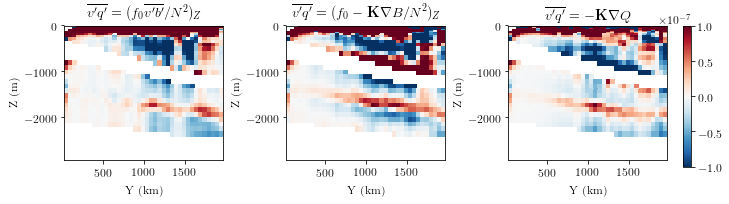

In [125]:
fig, ax = plt.subplots(1,3,figsize=(11,3))

ax[0].pcolormesh(Ycoarse/1e3, Z, vq.sel(XCicoarse=0), vmin=-1e-7, vmax=1e-7, cmap='RdBu_r',
                rasterized=True)
ax[0].set_title('$\overline{v\'q\'} = (f_0 \overline{v\'b\'} /N^2)_Z$ ')
ax[0].set_ylabel('Z (m)')
ax[0].set_xlabel('Y (km)')

ax[1].pcolormesh(Ycoarse/1e3, Z, vq2.sel(XCicoarse=0).T, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r',
                rasterized=True)
ax[1].set_title(r' $\overline{v^\prime q^\prime} = (f_0 -\mathbf{K} \nabla B /N^2)_Z$')
ax[1].set_ylabel('Z (m)')
ax[1].set_xlabel('Y (km)')

im = ax[2].pcolormesh(Ycoarse/1e3, Z, recVQ_corr.sel(XCicoarse=0).T, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r',
                     rasterized=True)
ax[2].set_title(r' $\overline{v^\prime q^\prime} = -\mathbf{K} \nabla Q$')
ax[2].set_ylabel('Z (m)')
ax[2].set_xlabel('Y (km)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

#plt.savefig('VQ_YZ_0km.pdf', dpi=400)

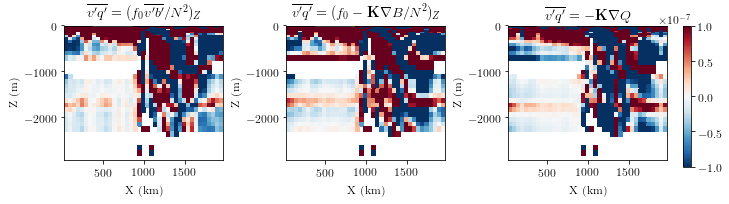

In [126]:
fig, ax = plt.subplots(1,3,figsize=(11,3))

ax[0].pcolormesh(Ycoarse/1e3, Z, vq.sel(YCicoarse=20), vmin=-1e-7, vmax=1e-7, cmap='RdBu_r',
                rasterized=True)
ax[0].set_title('$\overline{v\'q\'} = (f_0 \overline{v\'b\'} /N^2)_Z$ ')
ax[0].set_ylabel('Z (m)')
ax[0].set_xlabel('X (km)')

ax[1].pcolormesh(Ycoarse/1e3, Z, vq2.sel(YCicoarse=20).T, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r',
                rasterized=True)
ax[1].set_title(r' $\overline{v^\prime q^\prime} = (f_0 -\mathbf{K} \nabla B /N^2)_Z$')
ax[1].set_ylabel('Z (m)')
ax[1].set_xlabel('X (km)')

im = ax[2].pcolormesh(Ycoarse/1e3, Z, recVQ_corr.sel(YCicoarse=20).T, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r',
                     rasterized=True)
ax[2].set_title(r' $\overline{v^\prime q^\prime} = -\mathbf{K} \nabla Q$')
ax[2].set_ylabel('Z (m)')
ax[2].set_xlabel('X (km)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

#plt.savefig('VQ_XZ_1000km.pdf', dpi=400)

# Model Forcing

In [137]:
[Xg, Yg] = np.meshgrid(X,Y)

In [138]:
# Bathymetry
H = 3000.0 
h0 = 1000.0
sig = 75.0e3

#bathy = -(H + h)
#bathy = H - h0 * np.exp(-(xc - Lx/2)**2 / sig**2)
bathy =  -(H- h0*np.exp(-(Xg - Lx/2)**2 / sig**2))
bathy[1,:] = 0.0


(0, 2000)

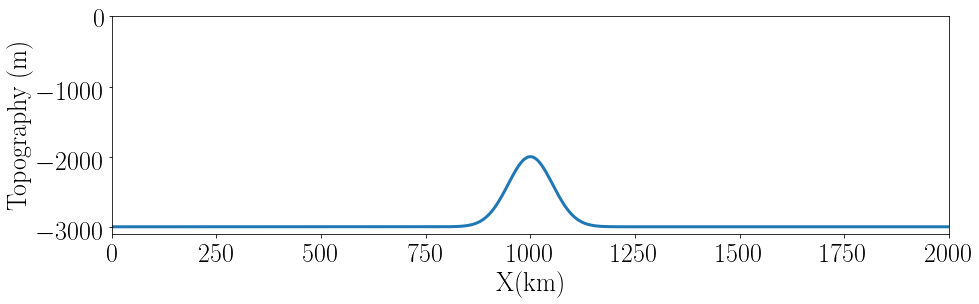

In [141]:
plt.figure(figsize=(15,4))
plt.rcParams['font.size']=26
plt.plot(X/1e3,(bathy[10,:]),'-',linewidth=3)
plt.xlabel('X(km)')
plt.ylabel('Topography (m)')
plt.ylim([-3100, 0])
plt.xlim([0, 2000])

In [152]:
# Winds
tau0 = 0.2

a =100e3 # the narrowness of the 
L =2000e3
tau = tau0*(np.sin(np.pi* (Yg)/(L))) # slightly squeezed wind profile to account 


(-0.0, 0.22)

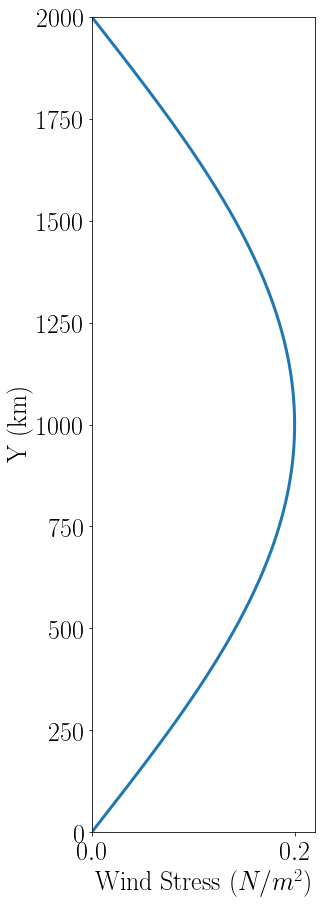

In [151]:
plt.figure(figsize=(4,15))
plt.rcParams['font.size']=26
plt.plot(tau[:,1],Y/1000,linewidth=3)
plt.xlabel('Wind Stress $(N/m^2)$')
plt.ylabel('Y (km)')
plt.ylim([0,2000])
plt.xlim([-0.0, 0.22])

In [156]:
# Surface B 
Tmin, Tmax = 0., 8.0
n=400 # num of grid points 
Tsurf = np.tile(np.linspace(Tmin, Tmax, n), (n,1)).T


([<matplotlib.axis.XTick at 0x7feb6494d240>,
 <a list of 2 Text xticklabel objects>)

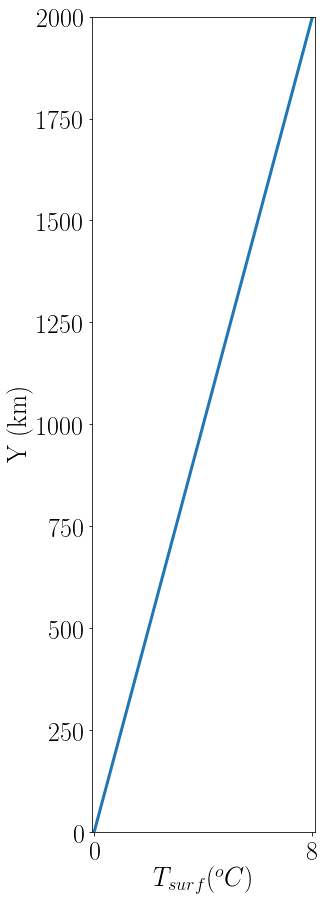

In [157]:
plt.figure(figsize=(4,15))
plt.rcParams['font.size']=26
plt.plot(Tsurf[:,1],Y/1000,linewidth=3)
plt.xlabel('$T_{surf} (^oC)$')
plt.ylabel('Y (km)')
plt.ylim([0,2000])
plt.xlim([-0.1, 8.1])
plt.xticks([0,8])